In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchsummary import summary
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 34.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


In [ ]:
class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_planes = 64  # Increased number of initial channels

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Increased initial channels
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)  # Increased channels
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)  # Increased channels
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = nn.functional.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
def ResNetModel():
    return ModifiedResNet(BasicBlock, [2,2,2])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_loss /= len(testloader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        scheduler.step(test_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Curves')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy Curves')
    plt.legend()
    plt.show()

    print('Final Test Accuracy: {:.4f}'.format(test_acc))

In [ ]:
model = ModifiedResNet(BasicBlock, [4,4,3])
model.to(device)

ModifiedResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [ ]:
print(summary(model, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/75], Train Loss: 1.7017, Train Acc: 0.3663, Test Loss: 1.6462, Test Acc: 0.4165
Epoch [2/75], Train Loss: 1.3045, Train Acc: 0.5284, Test Loss: 1.2194, Test Acc: 0.5591
Epoch [3/75], Train Loss: 1.1131, Train Acc: 0.6015, Test Loss: 1.0961, Test Acc: 0.6206
Epoch [4/75], Train Loss: 0.9899, Train Acc: 0.6506, Test Loss: 1.4326, Test Acc: 0.5849
Epoch [5/75], Train Loss: 0.8840, Train Acc: 0.6899, Test Loss: 0.9920, Test Acc: 0.6885
Epoch [6/75], Train Loss: 0.8011, Train Acc: 0.7183, Test Loss: 1.0381, Test Acc: 0.6838
Epoch [7/75], Train Loss: 0.7484, Train Acc: 0.7391, Test Loss: 0.9165, Test Acc: 0.7164
Epoch [8/75], Train Loss: 0.6975, Train Acc: 0.7565, Test Loss: 0.6394, Test Acc: 0.7852
Epoch [9/75], Train Loss: 0.6562, Train Acc: 0.7729, Test Loss: 0.7843, Test Acc: 0.7497
Epoch [10/75], Train Loss: 0.6224, Train Acc: 0.7824, Test Loss: 0.5331, Test Acc: 0.8146
Epoch [11/75], Train Loss: 0.5959, Train Acc: 0.7938, Test Loss: 0.6056, Test Acc: 0.8043
Epoch [12/75], Trai

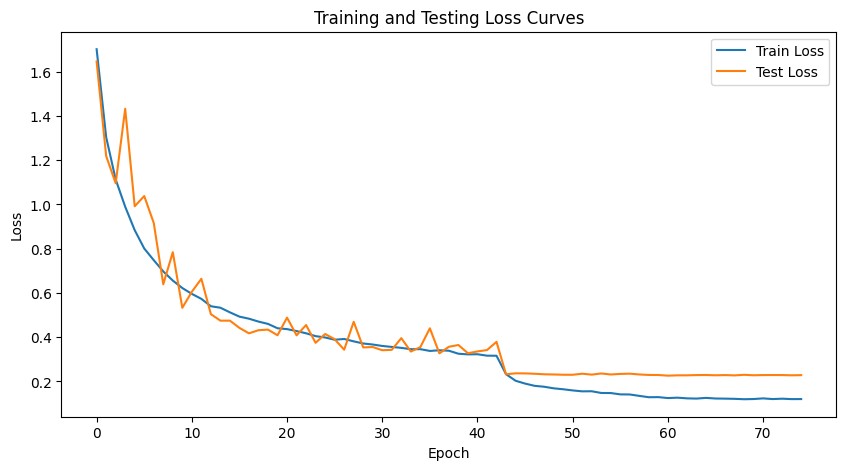

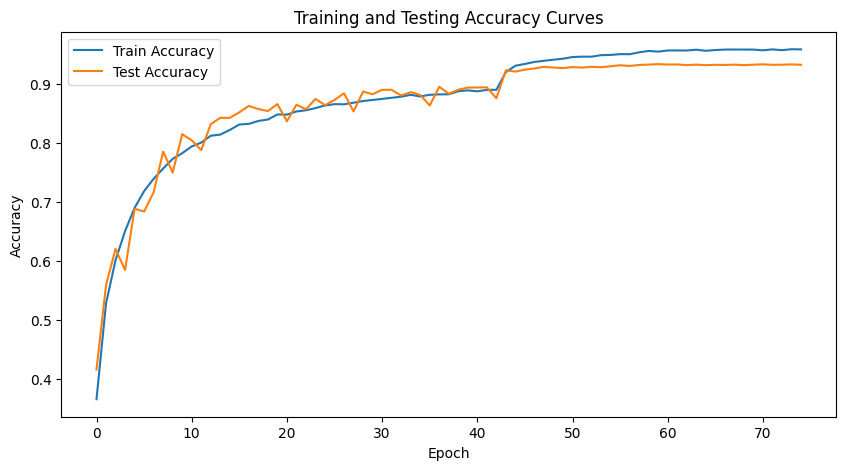

Final Test Accuracy: 0.9320
Model saved successfully!


In [ ]:
train_model(model, criterion, optimizer, scheduler, num_epochs=75)
torch.save(model.state_dict(), 'best_model.pth')
print('Model saved successfully!')

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy on the dataset: {100 * accuracy:.2f}%')

evaluate_model(model, testloader)

Accuracy on the dataset: 93.20%


In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import pickle
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

with open("/content/cifar_test_nolabel.pkl", "rb") as f:
    test_data = pickle.load(f)
image_ids = test_data[b'ids']
images = test_data[b'data']


images = torch.stack([transform(image) for image in images])


batch_size = 128
dataset = TensorDataset(images)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ModifiedResNet(BasicBlock, [4,4,3])
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

all_predictions = []
with torch.no_grad():
    for images_batch in data_loader:
        images_batch = images_batch[0].to(device)
        outputs = model(images_batch)
        _, predicted_labels = torch.max(outputs, 1)
        all_predictions.extend(predicted_labels.cpu().numpy())

df = pd.DataFrame({"ID": image_ids, "Labels": all_predictions})
df.to_csv("predictions.csv", index=False)

print("Predictions saved to predictions.csv")


<ipython-input-19-3935c750fd1f>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


Predictions saved to predictions.csv
